# Introduction

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Load Data

In [3]:
human_dates_raw = []
human_vocab = set()
machine_dates_raw = []
machine_vocab = set()
with open(os.path.expanduser('~/dates.csv'), 'r') as f:
    for line in f:
        h, m = line.strip().split(',')
        human_dates_raw.append(h)
        human_vocab.update(h)
        machine_dates_raw.append(m)
        machine_vocab.update(m)
        
#human_vocab = ['<pad>', *sorted(human_vocab)]
#machine_vocab = sorted(machine_vocab)

In [4]:
print(human_dates_raw[:4])

['9 may 1998', '10.09.70', '4/28/90', 'thursday january 26 1995']


In [5]:
print(machine_dates_raw[:4])

['1998-05-09', '1970-09-10', '1990-04-28', '1995-01-26']


In [6]:
print('human_vocab:  ', sorted(human_vocab))
print('machine_vocab:', sorted(machine_vocab))

human_vocab:   [' ', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
machine_vocab: ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
human_sym2idx = {c : i for i, c in enumerate(sorted(human_vocab), 1)}  # reserve 0 for input padding
print(human_sym2idx)

{' ': 1, '.': 2, '/': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'y': 35}


In [8]:
machine_sym2idx = {c : i for i, c in enumerate(sorted(machine_vocab))}
machine_idx2sym = {i : c for c, i in machine_sym2idx.items()}
print('machine_sym2idx:', machine_sym2idx)
print('machine_idx2sym:', machine_idx2sym)

machine_sym2idx: {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
machine_idx2sym: {0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


In [9]:
human_min_len = len(min(human_dates_raw, key=len))
human_max_len = len(max(human_dates_raw, key=len))
machine_min_len = len(min(machine_dates_raw, key=len))
machine_max_len = len(max(machine_dates_raw, key=len))
assert machine_min_len == machine_max_len == 10  # sanity check
print('Human dates min-max len:', human_min_len, '-', human_max_len)

Human dates min-max len: 6 - 27


In [10]:
def tokenize(list_of_examples, sym2idx):
    result_tokenized = []
    for list_of_symbols in list_of_examples:
        result_tokenized.append( [sym2idx[s] for s in list_of_symbols] )
    return result_tokenized

In [11]:
human_dates_tok = tokenize(human_dates_raw, human_sym2idx)
display(human_dates_tok[:3])

[[13, 1, 25, 14, 35, 1, 5, 13, 13, 12],
 [5, 4, 2, 4, 13, 2, 11, 4],
 [8, 3, 6, 12, 3, 13, 4]]

In [12]:
machine_dates_tok = tokenize(machine_dates_raw, machine_sym2idx)
display(machine_dates_tok[:3])

[[2, 10, 10, 9, 0, 1, 6, 0, 1, 10],
 [2, 10, 8, 1, 0, 1, 10, 0, 2, 1],
 [2, 10, 10, 1, 0, 1, 5, 0, 3, 9]]

In [13]:
def pad(list_of_examples, target_len, dtype):
    result_np = np.zeros(shape=(len(list_of_examples), target_len), dtype=dtype)
    
    for i in range(len(list_of_examples)):
        example = list_of_examples[i]
        result_np[i, 0:len(example)] = example
        
    return result_np

In [14]:
human_dates_pad = pad(human_dates_tok, human_max_len, dtype=int)
print('shape:', human_dates_pad.shape)
for i in range(3):
    print(human_dates_pad[i][:20])

shape: (10000, 27)
[13  1 25 14 35  1  5 13 13 12  0  0  0  0  0  0  0  0  0  0]
[ 5  4  2  4 13  2 11  4  0  0  0  0  0  0  0  0  0  0  0  0]
[ 8  3  6 12  3 13  4  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [15]:
machine_dates_pad = np.array(machine_dates_tok)  # nothing to pad
print('shape:', machine_dates_pad.shape)
for i in range(3):
    print(machine_dates_pad[i])

shape: (10000, 10)
[ 2 10 10  9  0  1  6  0  1 10]
[ 2 10  8  1  0  1 10  0  2  1]
[ 2 10 10  1  0  1  5  0  3  9]


In [16]:
def onehot_2d(array, nb_class):
    assert len(array.shape) == 2
    
    result = np.zeros((*array.shape, nb_class))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            k = array[i, j]
            result[i, j, k] = 1
            
    return result

In [17]:
human_max_idx = max(human_sym2idx.values())
human_dates_oh = onehot_2d(human_dates_pad, human_max_idx+1)

In [18]:
machine_max_idx = max(machine_sym2idx.values())
machine_dates_oh = onehot_2d(machine_dates_pad, machine_max_idx+1)

In [19]:
print('date:', machine_dates_raw[0])
print('padded:', machine_dates_pad[0])
print('onehot:\n', machine_dates_oh[0])

date: 1998-05-09
padded: [ 2 10 10  9  0  1  6  0  1 10]
onehot:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [20]:
n_hseq = human_max_len
n_hout = human_max_idx + 1
n_mseq = machine_max_len
n_mout = machine_max_idx + 1
print('n_hseq', n_hseq)
print('n_hout', n_hout)
print('n_mseq', n_mseq)
print('n_mout', n_mout)

n_hseq 27
n_hout 36
n_mseq 10
n_mout 11


In [21]:
import tensorflow.keras.backend as K
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [22]:
# Defined shared layers as global variables
repeator = tf.keras.layers.RepeatVector(n_hseq)
concatenator = tf.keras.layers.Concatenate(axis=-1)
densor1 = tf.keras.layers.Dense(10, activation = "tanh")
densor2 = tf.keras.layers.Dense(1, activation = "relu")
activator = tf.keras.layers.Activation(softmax, name='attention_weights') # custom softmax
dotor = tf.keras.layers.Dot(axes = 1)

In [23]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [24]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = tf.keras.layers.LSTM(n_s, return_state = True)
output_layer = tf.keras.layers.Dense(n_mout, activation=softmax)

In [25]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = tf.keras.Input(shape=(Tx, human_vocab_size))
    s0 = tf.keras.Input(shape=(n_s,), name='s0')
    c0 = tf.keras.Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = tf.keras.Model([X, s0, c0], outputs)
    
    ### END CODE HERE ###
    
    return model

In [26]:
model = model(n_hseq, n_mseq, n_a, n_s, n_hout, n_mout)

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27, 36)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 27, 64)       17664       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 27, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                       
          

In [28]:
### START CODE HERE ### (≈2 lines)
opt = tf.keras.optimizers.Adam(lr = 0.005, beta_1=0.9, beta_2=0.999, decay = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

In [29]:
m = len(human_dates_oh)
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(machine_dates_oh.swapaxes(0,1))

**Target Output**

Epoch xx/xx
10000/10000 [==============================] - 15s 2ms/step - loss: 0.0543 - dense_3_loss: 0.0021 - dense_3_acc: 0.9998 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 1.0000 - dense_3_acc_3: 1.0000 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9982 - dense_3_acc_6: 0.9997 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.9958 - dense_3_acc_9: 0.9997

In [31]:
model.fit([human_dates_oh, s0, c0], outputs, epochs=10, batch_size=100)

Epoch 1/10
10000/10000 [==============================] - 23s 2ms/step - loss: 16.9381 - dense_2_loss: 2.5974 - dense_2_acc: 0.4908 - dense_2_acc_1: 0.7668 - dense_2_acc_2: 0.3423 - dense_2_acc_3: 0.0728 - dense_2_acc_4: 0.9207 - dense_2_acc_5: 0.2615 - dense_2_acc_6: 0.0382 - dense_2_acc_7: 0.9178 - dense_2_acc_8: 0.2206 - dense_2_acc_9: 0.0892
Epoch 2/10
10000/10000 [==============================] - 13s 1ms/step - loss: 9.4929 - dense_2_loss: 2.2341 - dense_2_acc: 0.9603 - dense_2_acc_1: 0.9617 - dense_2_acc_2: 0.5655 - dense_2_acc_3: 0.1859 - dense_2_acc_4: 1.0000 - dense_2_acc_5: 0.8229 - dense_2_acc_6: 0.2520 - dense_2_acc_7: 1.0000 - dense_2_acc_8: 0.4515 - dense_2_acc_9: 0.1658
Epoch 3/10
10000/10000 [==============================] - 13s 1ms/step - loss: 8.2470 - dense_2_loss: 2.0830 - dense_2_acc: 0.9709 - dense_2_acc_1: 0.9700 - dense_2_acc_2: 0.6583 - dense_2_acc_3: 0.2856 - dense_2_acc_4: 1.0000 - dense_2_acc_5: 0.9165 - dense_2_acc_6: 0.3684 - dense_2_acc_7: 1.0000 - dens

In [40]:
model.fit([human_dates_oh, s0, c0], outputs, epochs=10, batch_size=100, verbose=0)

In [41]:
model.fit([human_dates_oh, s0, c0], outputs, epochs=10, batch_size=100)

Epoch 1/10
10000/10000 [==============================] - 13s 1ms/step - loss: 0.9464 - dense_2_loss: 0.1604 - dense_2_acc: 0.9996 - dense_2_acc_1: 0.9999 - dense_2_acc_2: 0.9946 - dense_2_acc_3: 0.9916 - dense_2_acc_4: 1.0000 - dense_2_acc_5: 0.9821 - dense_2_acc_6: 0.9229 - dense_2_acc_7: 1.0000 - dense_2_acc_8: 0.9204 - dense_2_acc_9: 0.9597
Epoch 2/10
10000/10000 [==============================] - 13s 1ms/step - loss: 0.8789 - dense_2_loss: 0.1487 - dense_2_acc: 0.9997 - dense_2_acc_1: 0.9999 - dense_2_acc_2: 0.9953 - dense_2_acc_3: 0.9942 - dense_2_acc_4: 1.0000 - dense_2_acc_5: 0.9835 - dense_2_acc_6: 0.9266 - dense_2_acc_7: 1.0000 - dense_2_acc_8: 0.9294 - dense_2_acc_9: 0.9653
Epoch 3/10
10000/10000 [==============================] - 14s 1ms/step - loss: 0.8261 - dense_2_loss: 0.1387 - dense_2_acc: 0.9997 - dense_2_acc_1: 1.0000 - dense_2_acc_2: 0.9957 - dense_2_acc_3: 0.9962 - dense_2_acc_4: 1.0000 - dense_2_acc_5: 0.9831 - dense_2_acc_6: 0.9292 - dense_2_acc_7: 1.0000 - dense

In [52]:
#model.save_weights('2410_attention.h5')

In [30]:
#model.load_weights('2410_attention.h5')

In [31]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = onehot_2d(pad(tokenize([example.lower()], human_sym2idx), n_hseq, int), n_hout)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis=-1)
    output = [machine_idx2sym[i] for i in prediction.ravel()]
    
    print("source:", example)
    print("output:", ''.join(output))
    print()

source: 3 May 1979
output: 1979-05-03

source: 5 April 09
output: 2019-04-04

source: 21th of August 2016
output: 2016-08-01

source: Tue 10 Jul 2007
output: 2007-07-10

source: Saturday May 9 2018
output: 2018-05-09

source: March 3 2001
output: 2001-03-03

source: March 3rd 2001
output: 2001-03-03

source: 1 March 2001
output: 2001-03-01



In [32]:
print('n_hseq', n_hseq)
print('n_hout', n_hout)
print('n_mseq', n_mseq)
print('n_mout', n_mout)

n_hseq 27
n_hout 36
n_mseq 10
n_mout 11


In [33]:
def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((n_mseq, n_hseq))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = onehot_2d(pad(tokenize([text.lower()], human_sym2idx), n_hseq, int), n_hout)
    encoded = encoded.astype(np.float32)
    
    print(Ty)
    print(encoded.shape, encoded.dtype)
    print(s0.shape, s0.dtype)
    print(c0.shape, c0.dtype)
    #encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    #encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    #print(prediction)
    
    prediction = np.argmax(prediction, axis=-1)
    predicted_text = [machine_idx2sym[i] for i in prediction.ravel()]
    #print(predicted_text)
    
#     predicted_text = []
#     for i in range(len(prediction)):
#         predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
#     predicted_text = list(predicted_text)
#     print(predicted_text)
#     predicted_text = [machine_idx2sym[i] for i in predicted_text.ravel()]
    #predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

10
(1, 27, 36) float32
(1, 64) float64
(1, 64) float64


<Figure size 432x288 with 0 Axes>

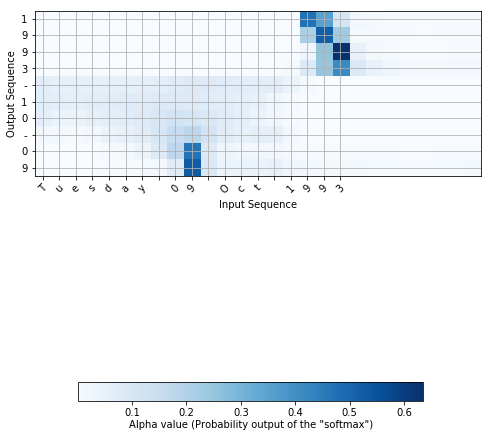

In [34]:
attention_map = plot_attention_map(model, human_sym2idx, machine_idx2sym, "Tuesday 09 Oct 1993", num=7, n_s = 64)

10
(1, 27, 36) float32
(1, 64) float64
(1, 64) float64


<Figure size 432x288 with 0 Axes>

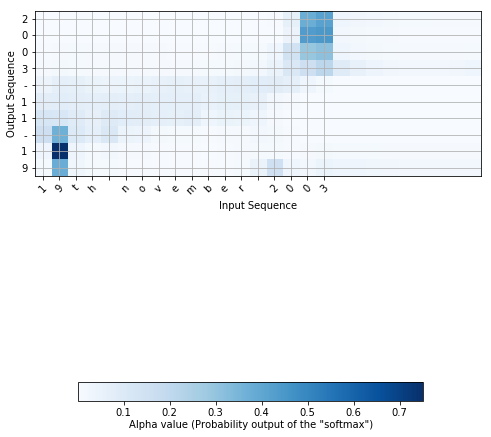

In [35]:
attention_map = plot_attention_map(model, human_sym2idx, machine_idx2sym, "19th november 2003", num=7, n_s = 64)